In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import json
import os

from IPython.display import display

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
test_stat_files = [os.path.normpath(path) for path in glob("../data/models_classification/*/test_stats.json")]
test_stat_files

['..\\data\\models_classification\\all_abusive_bilstm\\test_stats.json',
 '..\\data\\models_classification\\all_abusive_bilstm_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models_classification\\all_abusive_cnn_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models_classification\\all_multitask_shared_bilstm\\test_stats.json',
 '..\\data\\models_classification\\all_multitask_shared_bilstm_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models_classification\\all_multitask_shared_cnn_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models_classification\\all_multitask_stacked_bilstm\\test_stats.json',
 '..\\data\\models_classification\\all_multitask_stacked_bilstm_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models_classification\\all_multitask_stacked_cnn_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models_classification\\all_sentiment_bilstm\\test_stats.json',
 '..\\data\\models_classification\\all_sentiment_bilstm_l2_0_lr_1e-3\\test_stats.json',
 '..\\data\\models_classification\\all_sentiment_cnn_l

In [4]:
test_stat_files[0].split(os.sep)[-3:-1]

['models_classification', 'all_abusive_bilstm']

In [5]:
def parse_stats(stat, model):
    stats = []
    for task, task_stat in stat.items():
        task_suffix = task.rsplit("_")[-1]
        for file, file_stat in task_stat.items():
            file = os.path.normpath(file)
            file_stat = {
                k.rsplit("_")[-1]:v for k,v in file_stat.items()
                if k.endswith(("fscore", "precision", "recall", "accuracy"))
            }
            file_stat["file"] = "_".join(file.split(os.sep)[-3:-1])
            file_stat["task"] = task
            file_stat["task_type"] = task_suffix
            file_stat["model"] = model
            stats.append(file_stat)
    return stats

In [6]:
def parse_model_name(file):
    model = file.split(os.sep)[-2]
    model = model.replace("l2_0_lr_0.001", "*")
    model = model.replace("l2_0_lr_1e-3", "*")
    model = model.split("_")
    if model[0] != "all":
        model = ["S"] + model[2:]
    elif model[1] == "multitask":
        if model[2] == "stacked":
            model = ["MTL"]+model[3:]
        elif model[2] == "shared":
            model = ["MTS"]+model[3:]
    elif model[1] in {"sentiment", "uncertainity", "abusive"}:
        model = ["MD"]+model[2:]
    if len({"bilstm", "cnn"} & set(model)) == 0:
        model = model[:1] + ["bilstm"] + model[1:]
    # We cannot have different encoder for MTL stacked case, because of AllenNLP. It will be always biLSTM
    if model[1] == "cnn" and model[0] == "MTL":
        model[1] = "bilstm"
    model = " ".join(model)
    return model

 
def get_model_type(x):
    if x.startswith("S "): return "S"
    if x.startswith("MTL "): return "MTL"
    if x.startswith("MTS "): return "MTS"
    return "MD"
  
def get_model_params(x):
    if "*" in x: 
        return "reg"
    return "no_reg"

def get_layer_type(x):
    if "cnn" in x:
        return f"cnn"
    return f"bilstm"

In [7]:
stats = []
for file in test_stat_files:
    with open(file) as fp:
        stat = json.load(fp)
        model = parse_model_name(file)
        stats.extend(parse_stats(stat, model))
df = pd.DataFrame(stats).assign(
    model_type=lambda df_temp: pd.Categorical(
        df_temp["model"].map(get_model_type),
        categories=["S", "MD", "MTS", "MTL"],
        ordered=True
    ),
    is_regularized=lambda df_temp: df_temp["model"].str.contains("\*"),
    no_neel=lambda df_temp: df_temp["model"].str.contains("#"),
    regularized=lambda df_temp: df_temp["model"].map(get_model_params),
    layer_type=lambda df_temp: df_temp["model"].map(get_layer_type),
)
df.head()

,accuracy,file,fscore,model,precision,recall,task,task_type,model_type,is_regularized,no_neel,regularized,layer_type
0,0.790255,ABUSIVE_Founta,0.790255,MD bilstm,0.790255,0.790255,founta_abusive,abusive,MD,False,False,no_reg,bilstm
1,0.813064,ABUSIVE_WaseemSRW,0.813064,MD bilstm,0.813064,0.813064,waseem_abusive,abusive,MD,False,False,no_reg,bilstm
2,0.803466,ABUSIVE_Founta,0.803466,MD bilstm *,0.803466,0.803466,founta_abusive,abusive,MD,True,False,reg,bilstm
3,0.832195,ABUSIVE_WaseemSRW,0.832195,MD bilstm *,0.832195,0.832195,waseem_abusive,abusive,MD,True,False,reg,bilstm
4,0.801750,ABUSIVE_Founta,0.801750,MD cnn *,0.801750,0.801750,founta_abusive,abusive,MD,True,False,reg,cnn


In [8]:
df.layer_type.value_counts()

bilstm    90
cnn       30
Name: layer_type, dtype: int64

In [9]:
TRUE_MODEL_ORDER = df.groupby("model").first().assign(
    model_type=lambda x: pd.Categorical(x["model_type"], categories=["S", "MD", "MTS", "MTL"], ordered=True)
).sort_values(["layer_type", "no_neel", "is_regularized", "model_type", ], ascending=[True, True, True, True]).index.values
TRUE_MODEL_ORDER

array(['S bilstm', 'MD bilstm', 'MTS bilstm', 'MTL bilstm', 'S bilstm *',
       'MD bilstm *', 'MTS bilstm *', 'MTL bilstm *', 'S cnn *',
       'MD cnn *', 'MTS cnn *'], dtype=object)

In [10]:
def plot_measures(df, task, measure):
    df_tt = df[(df.task_type == task)][[
        measure, "file", "model", "model_type",
    ]].assign(
        # 2 task files can have same suffix so split here.
        file=lambda df_temp: df_temp["file"].str.split("_", 1, expand=True)[1], 
        **{
            measure: lambda df_temp: df_temp[measure]*100.
        }
    )
    df_t = df_tt.pivot_table(
        index="model",
        columns="file",
        values=measure,
        aggfunc="max"
    ).fillna(0)
    #df_t = df_t.assign(mean_value=df_t.mean(axis=1)).sort_values("mean_value", ascending=False).drop("mean_value", axis=1)
    sort_order = TRUE_MODEL_ORDER
    df_t = df_t.reindex(sort_order).dropna(axis=0)
    nmodels, ncols = df_t.shape
    display(df_t)
    nfig_cols = 3
    nrows = np.ceil(ncols/nfig_cols).astype(int)
    
    df_t_ranked = df_t.rank(ascending=False, method="min").astype(int)
    
    """
    df_t.plot(
        kind="barh", figsize=(20,(0.5*nmodels)*nrows), subplots=True, legend=False,
        sharex=False, color="0.5", layout=(nrows,nfig_cols), sharey=True
    )
    """
    y_col = "model"
    hue_col = "model_type"
    y_order = sort_order
    hue_order = df["model"].map(get_model_type).value_counts().index.values
    markers = ["o", "s", "*", "^", "v"][:hue_order.shape[0]]
    plot_height=np.max([4.0, 0.5*df_tt[y_col].value_counts().shape[0]])
    g = sns.FacetGrid(
        data=df_tt, 
        col="file", col_wrap=3,
        hue=hue_col, 
        hue_order=hue_order,
        height=plot_height, aspect=1,
        sharex=False,
        hue_kws=dict(marker=markers)
    )
    (g.map(sns.stripplot, measure, y_col, orient="h", size=20, order=y_order))
    #plt.tight_layout()
    
    
    df_t_merged = pd.concat([df_t_ranked, df_t], 
        keys=["r", "v"],
        axis=1
    ).reorder_levels([1, 0], axis=1).sort_index(axis=1)
    with pd.option_context("precision", 2):
        display(df_t_merged) 
        print(df_t_merged.to_latex(bold_rows=True, multicolumn_format='c'))
    
    fig = plt.figure(figsize=(10, 10))
    print(df_t.columns)
    sns.heatmap(
        df_t_ranked.T, 
        cmap="viridis_r", linewidths=.5, annot=True, fmt="d",
        square=True,
        cbar=False,
        cbar_kws = dict(use_gridspec=False,location="top")
    )
    
    display(pd.concat([df_t.idxmax(), df_t.max()], axis=1, keys=["model", "score"]))
    return df_t_merged

file,Airline,Clarin,GOP,Healthcare,Obama,SemEval
model,,,,,,
S bilstm,80.464923,65.712667,67.048854,63.877267,59.003830,65.571570
MD bilstm,79.771614,65.282959,65.952146,60.948396,59.578544,67.051899
MTS bilstm,63.213706,47.365007,56.779659,60.251045,38.888887,40.427649
MTL bilstm,63.703102,47.000164,45.214358,59.693164,44.636014,49.924251
S bilstm *,81.688416,67.707151,67.547357,65.969318,62.643677,66.467559
MD bilstm *,81.851548,66.231555,66.500497,64.853555,61.685824,68.978053
MTS bilstm *,81.647635,66.547751,67.447656,66.806138,60.344827,69.523436
MTL bilstm *,82.218599,67.601752,68.095714,67.085075,61.302680,69.103581
S cnn *,82.096249,68.177396,68.893319,62.343097,62.643677,66.194868


file         Airline        Clarin        GOP        Healthcare        Obama  \
                   r      v      r      v   r      v          r      v     r   
model                                                                          
S bilstm           8  80.46      8  65.71   5  67.05          6  63.88     9   
MD bilstm          9  79.77      9  65.28   8  65.95          9  60.95     8   
MTS bilstm        11  63.21     10  47.37  10  56.78         10  60.25    11   
MTL bilstm        10  63.70     11  47.00  11  45.21         11  59.69    10   
S bilstm *         6  81.69      3  67.71   3  67.55          3  65.97     1   
MD bilstm *        5  81.85      7  66.23   7  66.50          4  64.85     3   
MTS bilstm *       7  81.65      6  66.55   4  67.45          2  66.81     7   
MTL bilstm *       2  82.22      4  67.60   2  68.10          1  67.09     6   
S cnn *            3  82.10      1  68.18   1  68.89          8  62.34     1   
MD cnn *           1  82.54      5  67.01   6  66.65          7  63.18     5   
MTS cnn *          4  82.06      2  67.72   9  64.81          5  64.57     3   

file                SemEval         
                  v       r      v  
model                               
S bilstm      59.00       9  65.57  
MD bilstm     59.58       6  67.05  
MTS bilstm    38.89      11  40.43  
MTL bilstm    44.64      10  49.92  
S bilstm *    62.64       7  66.47  
MD bilstm *   61.69       3  68.98  
MTS bilstm *  60.34       1  69.52  
MTL bilstm *  61.30       2  69.10  
S cnn *       62.64       8  66.19  
MD cnn *      61.49       4  68.04  
MTS cnn *     61.69       5  67.63

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{Airline} & \multicolumn{2}{c}{Clarin} & \multicolumn{2}{c}{GOP} & \multicolumn{2}{c}{Healthcare} & \multicolumn{2}{c}{Obama} & \multicolumn{2}{c}{SemEval} \\
{} &       r &      v &      r &      v &   r &      v &          r &      v &     r &      v &       r &      v \\
\textbf{model       } &         &        &        &        &     &        &            &        &       &        &         &        \\
\midrule
\textbf{S bilstm    } &       8 &  80.46 &      8 &  65.71 &   5 &  67.05 &          6 &  63.88 &     9 &  59.00 &       9 &  65.57 \\
\textbf{MD bilstm   } &       9 &  79.77 &      9 &  65.28 &   8 &  65.95 &          9 &  60.95 &     8 &  59.58 &       6 &  67.05 \\
\textbf{MTS bilstm  } &      11 &  63.21 &     10 &  47.37 &  10 &  56.78 &         10 &  60.25 &    11 &  38.89 &      11 &  40.43 \\
\textbf{MTL bilstm  } &      10 &  63.70 &     11 &  47.00 &  11 &  45.21 &         11 &  59.69 &    1

,model,score
file,,
Airline,MD cnn *,82.544863
Clarin,S cnn *,68.177396
GOP,S cnn *,68.893319
Healthcare,MTL bilstm *,67.085075
Obama,S bilstm *,62.643677
SemEval,MTS bilstm *,69.523436


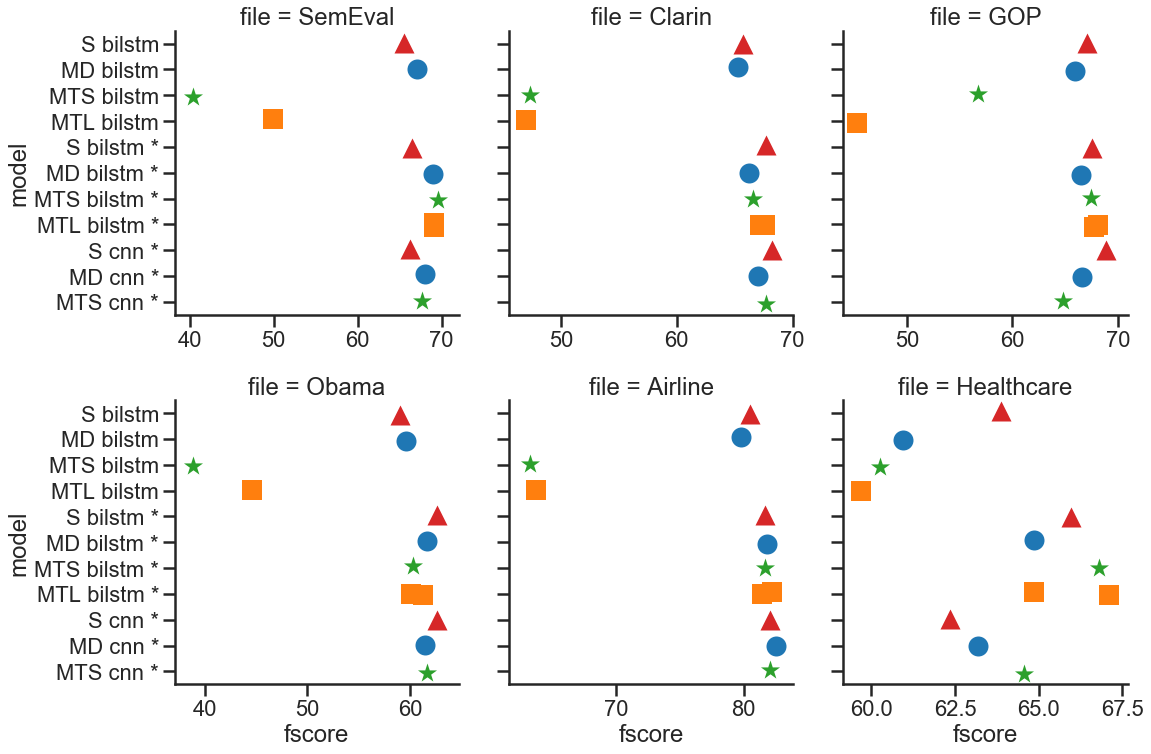

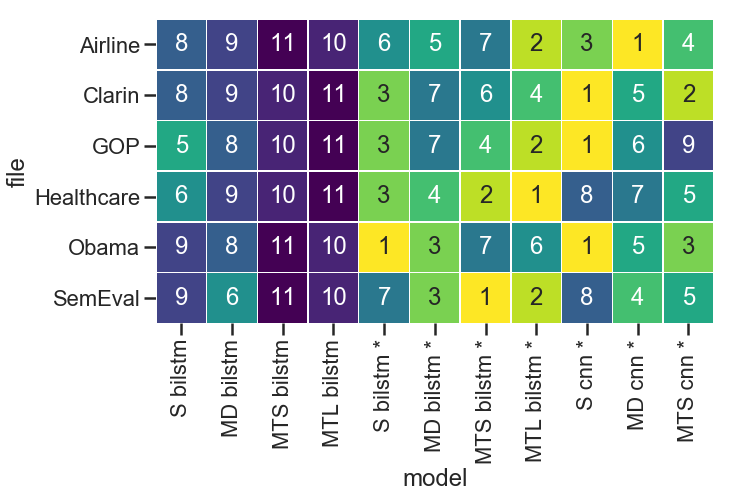

In [11]:
df_t_sentiment = plot_measures(df, task="sentiment", measure="fscore")

file,Riloff,Swamy
model,,
S bilstm,81.215471,38.797814
MD bilstm,79.281765,39.344263
MTS bilstm,58.839780,27.868852
MTL bilstm,58.011049,23.497267
S bilstm *,83.425409,39.344263
MD bilstm *,80.939227,39.344263
MTS bilstm *,82.596684,38.251367
MTL bilstm *,83.977902,39.344263
S cnn *,85.635358,35.519126


file         Riloff        Swamy       
                  r      v     r      v
model                                  
S bilstm          6  81.22     5  38.80
MD bilstm         9  79.28     1  39.34
MTS bilstm       10  58.84    10  27.87
MTL bilstm       11  58.01    11  23.50
S bilstm *        3  83.43     1  39.34
MD bilstm *       7  80.94     1  39.34
MTS bilstm *      5  82.60     6  38.25
MTL bilstm *      2  83.98     1  39.34
S cnn *           1  85.64     7  35.52
MD cnn *          4  83.15     8  32.79
MTS cnn *         8  80.11     9  31.15

\begin{tabular}{lrrrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{Riloff} & \multicolumn{2}{c}{Swamy} \\
{} &      r &      v &     r &      v \\
\textbf{model       } &        &        &       &        \\
\midrule
\textbf{S bilstm    } &      6 &  81.22 &     5 &  38.80 \\
\textbf{MD bilstm   } &      9 &  79.28 &     1 &  39.34 \\
\textbf{MTS bilstm  } &     10 &  58.84 &    10 &  27.87 \\
\textbf{MTL bilstm  } &     11 &  58.01 &    11 &  23.50 \\
\textbf{S bilstm *  } &      3 &  83.43 &     1 &  39.34 \\
\textbf{MD bilstm * } &      7 &  80.94 &     1 &  39.34 \\
\textbf{MTS bilstm *} &      5 &  82.60 &     6 &  38.25 \\
\textbf{MTL bilstm *} &      2 &  83.98 &     1 &  39.34 \\
\textbf{S cnn *     } &      1 &  85.64 &     7 &  35.52 \\
\textbf{MD cnn *    } &      4 &  83.15 &     8 &  32.79 \\
\textbf{MTS cnn *   } &      8 &  80.11 &     9 &  31.15 \\
\bottomrule
\end{tabular}

Index(['Riloff', 'Swamy'], dtype='object', name='file')


,model,score
file,,
Riloff,S cnn *,85.635358
Swamy,MD bilstm,39.344263


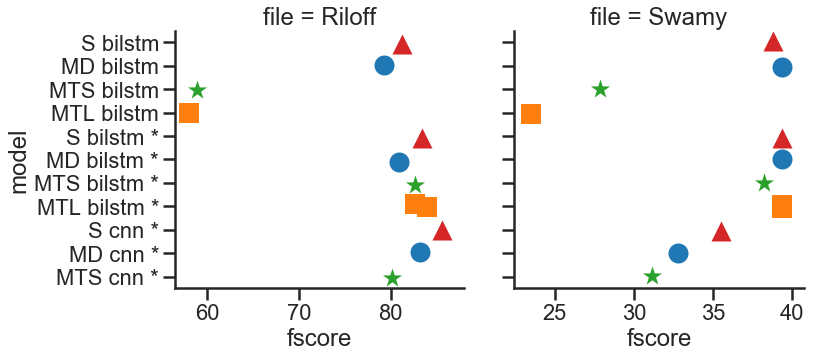

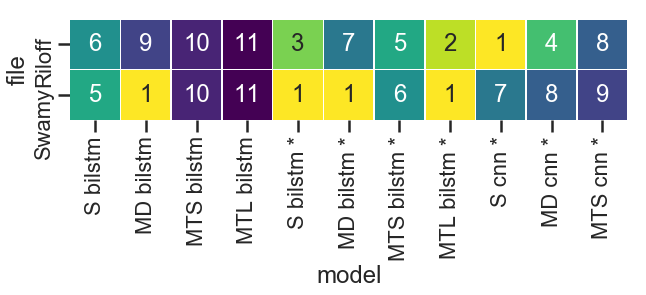

In [12]:
df_t_uncertainity = plot_measures(df, task="uncertainity", measure="fscore")

file,Founta,WaseemSRW
model,,
S bilstm,79.334307,81.716317
MD bilstm,79.025477,81.306368
MTS bilstm,61.482370,68.570650
MTL bilstm,69.263107,70.128453
S bilstm *,80.603927,82.946157
MD bilstm *,80.346572,83.219457
MTS bilstm *,80.106372,81.989616
MTL bilstm *,80.226475,82.782179
S cnn *,80.252206,82.891500


file         Founta        WaseemSRW       
                  r      v         r      v
model                                      
S bilstm          8  79.33         8  81.72
MD bilstm         9  79.03         9  81.31
MTS bilstm       11  61.48        11  68.57
MTL bilstm       10  69.26        10  70.13
S bilstm *        1  80.60         3  82.95
MD bilstm *       2  80.35         2  83.22
MTS bilstm *      6  80.11         7  81.99
MTL bilstm *      4  80.23         5  82.78
S cnn *           3  80.25         4  82.89
MD cnn *          5  80.18         1  84.42
MTS cnn *         7  79.92         6  82.67

\begin{tabular}{lrrrr}
\toprule
\textbf{file} & \multicolumn{2}{c}{Founta} & \multicolumn{2}{c}{WaseemSRW} \\
{} &      r &      v &         r &      v \\
\textbf{model       } &        &        &           &        \\
\midrule
\textbf{S bilstm    } &      8 &  79.33 &         8 &  81.72 \\
\textbf{MD bilstm   } &      9 &  79.03 &         9 &  81.31 \\
\textbf{MTS bilstm  } &     11 &  61.48 &        11 &  68.57 \\
\textbf{MTL bilstm  } &     10 &  69.26 &        10 &  70.13 \\
\textbf{S bilstm *  } &      1 &  80.60 &         3 &  82.95 \\
\textbf{MD bilstm * } &      2 &  80.35 &         2 &  83.22 \\
\textbf{MTS bilstm *} &      6 &  80.11 &         7 &  81.99 \\
\textbf{MTL bilstm *} &      4 &  80.23 &         5 &  82.78 \\
\textbf{S cnn *     } &      3 &  80.25 &         4 &  82.89 \\
\textbf{MD cnn *    } &      5 &  80.18 &         1 &  84.42 \\
\textbf{MTS cnn *   } &      7 &  79.92 &         6 &  82.67 \\
\bottomrule
\end{tabular}

Index(['Founta', 'WaseemSRW'], dtype='obj

,model,score
file,,
Founta,S bilstm *,80.603927
WaseemSRW,MD cnn *,84.421974


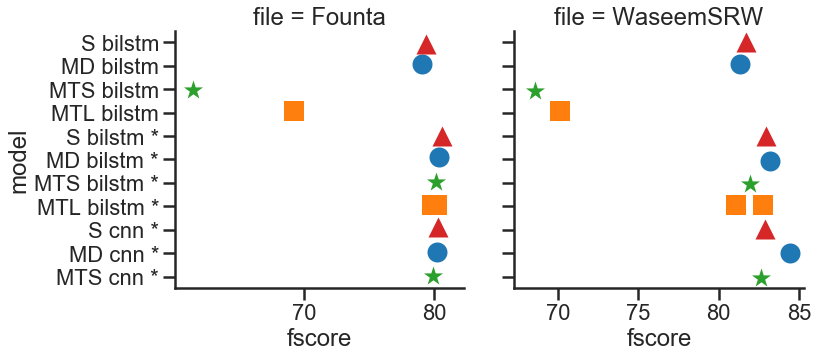

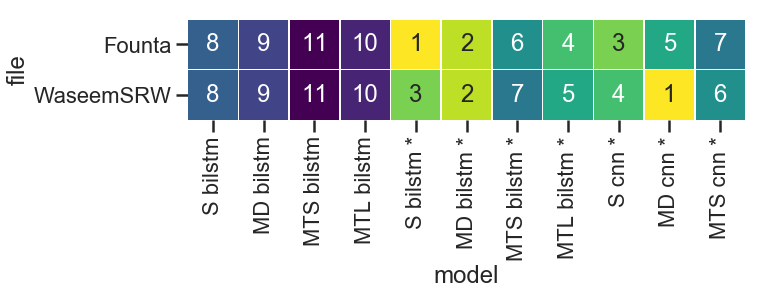

In [13]:
df_t_abusive = plot_measures(df, task="abusive", measure="fscore")

In [14]:
df_t_all_ranks = pd.concat({
    "sentiment": df_t_sentiment.xs("r", level=1, axis=1),
    "abusive": df_t_abusive.xs("r", level=1, axis=1),
    "uncertainity": df_t_uncertainity.xs("r", level=1, axis=1),
}, axis=1, sort=False).astype(float)

df_t_all_eval_scores = pd.concat({
    "sentiment": df_t_sentiment.xs("v", level=1, axis=1),
    "abusive": df_t_abusive.xs("v", level=1, axis=1),
    "uncertainity": df_t_uncertainity.xs("v", level=1, axis=1),
}, axis=1, sort=False).astype(float)

df_t_all_ranks

abusive           sentiment                                \
file          Founta WaseemSRW   Airline Clarin   GOP Healthcare Obama   
model                                                                    
S bilstm         8.0       8.0       8.0    8.0   5.0        6.0   9.0   
MD bilstm        9.0       9.0       9.0    9.0   8.0        9.0   8.0   
MTS bilstm      11.0      11.0      11.0   10.0  10.0       10.0  11.0   
MTL bilstm      10.0      10.0      10.0   11.0  11.0       11.0  10.0   
S bilstm *       1.0       3.0       6.0    3.0   3.0        3.0   1.0   
MD bilstm *      2.0       2.0       5.0    7.0   7.0        4.0   3.0   
MTS bilstm *     6.0       7.0       7.0    6.0   4.0        2.0   7.0   
MTL bilstm *     4.0       5.0       2.0    4.0   2.0        1.0   6.0   
S cnn *          3.0       4.0       3.0    1.0   1.0        8.0   1.0   
MD cnn *         5.0       1.0       1.0    5.0   6.0        7.0   5.0   
MTS cnn *        7.0       6.0       4.0    2.0   9.0        5.0   3.0   

                     uncertainity        
file         SemEval       Riloff Swamy  
model                                    
S bilstm         9.0          6.0   5.0  
MD bilstm        6.0          9.0   1.0  
MTS bilstm      11.0         10.0  10.0  
MTL bilstm      10.0         11.0  11.0  
S bilstm *       7.0          3.0   1.0  
MD bilstm *      3.0          7.0   1.0  
MTS bilstm *     1.0          5.0   6.0  
MTL bilstm *     2.0          2.0   1.0  
S cnn *          8.0          1.0   7.0  
MD cnn *         4.0          4.0   8.0  
MTS cnn *        5.0          8.0   9.0

In [15]:
with pd.option_context("precision", 2):
    display(df_t_all_eval_scores)
    print(df_t_all_eval_scores.to_latex(bold_rows=True, multicolumn_format='c', na_rep="-"))

abusive           sentiment                                  \
file          Founta WaseemSRW   Airline Clarin    GOP Healthcare  Obama   
model                                                                      
S bilstm       79.33     81.72     80.46  65.71  67.05      63.88  59.00   
MD bilstm      79.03     81.31     79.77  65.28  65.95      60.95  59.58   
MTS bilstm     61.48     68.57     63.21  47.37  56.78      60.25  38.89   
MTL bilstm     69.26     70.13     63.70  47.00  45.21      59.69  44.64   
S bilstm *     80.60     82.95     81.69  67.71  67.55      65.97  62.64   
MD bilstm *    80.35     83.22     81.85  66.23  66.50      64.85  61.69   
MTS bilstm *   80.11     81.99     81.65  66.55  67.45      66.81  60.34   
MTL bilstm *   80.23     82.78     82.22  67.60  68.10      67.09  61.30   
S cnn *        80.25     82.89     82.10  68.18  68.89      62.34  62.64   
MD cnn *       80.18     84.42     82.54  67.01  66.65      63.18  61.49   
MTS cnn *      79.92     82.67     82.06  67.72  64.81      64.57  61.69   

                     uncertainity         
file         SemEval       Riloff  Swamy  
model                                     
S bilstm       65.57        81.22  38.80  
MD bilstm      67.05        79.28  39.34  
MTS bilstm     40.43        58.84  27.87  
MTL bilstm     49.92        58.01  23.50  
S bilstm *     66.47        83.43  39.34  
MD bilstm *    68.98        80.94  39.34  
MTS bilstm *   69.52        82.60  38.25  
MTL bilstm *   69.10        83.98  39.34  
S cnn *        66.19        85.64  35.52  
MD cnn *       68.04        83.15  32.79  
MTS cnn *      67.63        80.11  31.15

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{abusive} & \multicolumn{6}{c}{sentiment} & \multicolumn{2}{c}{uncertainity} \\
\textbf{file} &  Founta & WaseemSRW &   Airline & Clarin &    GOP & Healthcare &  Obama & SemEval &       Riloff &  Swamy \\
\textbf{model       } &         &           &           &        &        &            &        &         &              &        \\
\midrule
\textbf{S bilstm    } &   79.33 &     81.72 &     80.46 &  65.71 &  67.05 &      63.88 &  59.00 &   65.57 &        81.22 &  38.80 \\
\textbf{MD bilstm   } &   79.03 &     81.31 &     79.77 &  65.28 &  65.95 &      60.95 &  59.58 &   67.05 &        79.28 &  39.34 \\
\textbf{MTS bilstm  } &   61.48 &     68.57 &     63.21 &  47.37 &  56.78 &      60.25 &  38.89 &   40.43 &        58.84 &  27.87 \\
\textbf{MTL bilstm  } &   69.26 &     70.13 &     63.70 &  47.00 &  45.21 &      59.69 &  44.64 &   49.92 &        58.01 &  23.50 \\
\textbf{S bilstm *  } &   80.60 &     82.95 &     81.69 &  6

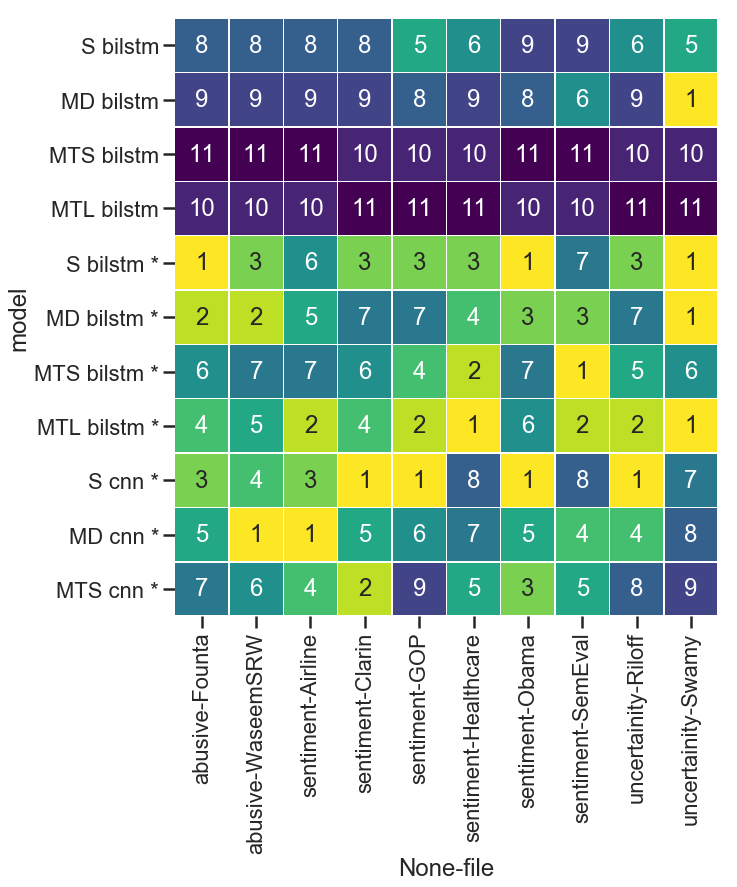

In [16]:
fig = plt.figure(
    figsize=(1*df_t_all_ranks.shape[1], 1*df_t_all_ranks.shape[0])
)

std_eval_scores = (df_t_all_eval_scores - df_t_all_eval_scores.max(axis=0)).divide(df_t_all_eval_scores.std(axis=0))

sns.heatmap(
    #df_t_all_ranks.reindex(std_eval_scores.mean(axis=1).sort_values(ascending=False).index.values, axis=0), 
    df_t_all_ranks.reindex(TRUE_MODEL_ORDER),
    cmap="viridis_r", linewidths=.5, annot=True, fmt=".0f",
    square=True,
    cbar=False
)